In [1]:
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 3
augment = 8

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(4)


def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            'dataset': "MNIST",
            # 'dataset': "FashionMNIST",
            'random_class_idx': False,

            # benchmark
            'seed': seed,
            'num_tasks': 5,
            'epochs_per_task': 5,
            'per_task_examples': np.inf,
            # 'per_task_examples': 2000,
            'per_task_memory_examples': 64,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 10.,
            # 'tau': 0.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.001,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            'device': torch.device('cuda:2' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha':0.001,
            'lambda': 1.,
            'lambda_old': 0.0,
              }

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_alpha={params['alpha']}_tau={params['tau']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=MNIST/seed=3_epoch=5_lr=0.001_alpha=0.001_tau=10.0


In [2]:
from datasets import MNIST
from datasets import FashionMNIST
from datasets import CIFAR10, CIFAR100

if params['dataset'] == 'MNIST':
    benchmark = MNIST(num_tasks=params['num_tasks'],
                    per_task_memory_examples=params['per_task_memory_examples'],
                    per_task_examples = params['per_task_examples'],
                    random_class_idx = params['random_class_idx'],
                    augment=augment)
    input_dim = (28, 28)
elif params['dataset'] == 'FashionMNIST':
    benchmark = FashionMNIST(num_tasks=params['num_tasks'],
                            per_task_memory_examples=params['per_task_memory_examples'],
                            per_task_examples = params['per_task_examples'],
                            random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
elif params['dataset'] == 'CIFAR10':
    benchmark = CIFAR10(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
elif params['dataset'] == 'CIFAR100':        
    benchmark = CIFAR100(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
else:
    raise NotImplementedError
class_idx = benchmark.class_idx
num_classes = len(class_idx)



[0 1 2 3 4 5 6 7 8 9]


In [3]:
from algorithms.imbalance import Heuristic2
from metrics import MetricCollector2
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])
algorithm = Heuristic2(backbone, benchmark, params, requires_memory=True)
metric_manager_callback = MetricCollector2(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])

In [4]:
# from trainers import ContinualTrainer
# from trainers.fair_trainer import FairContinualTrainer2 as ContinualTrainer
from trainers.imbalance_trainer import ImbalanceContinualTrainer1 as ContinualTrainer

trainer = ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 1.0893822936054944e-05, 'std': 0.0010204081632653184, 'EER': -1}
[2] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 8.477443217103927e-06, 'std': 0.0010204081632653184, 'EER': -1}
[3] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 7.751771538814498e-06, 'std': 0.0010204081632653184, 'EER': -1}
[4] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 7.582643462469401e-06, 'std': 0.0010204081632653184, 'EER': -1}
[5] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 7.756863205790538e-06, 'std': 0.0010204081632653184, 'EER': -1}
training_task_end
---------------------------- Task 2 -----------------------
losses=tensor([[6.9688e-04, 6.3377e-05, 1.2194e+01, 1.1533e+01]])
Elapsed time(grad):143.822
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):487.364
Fair

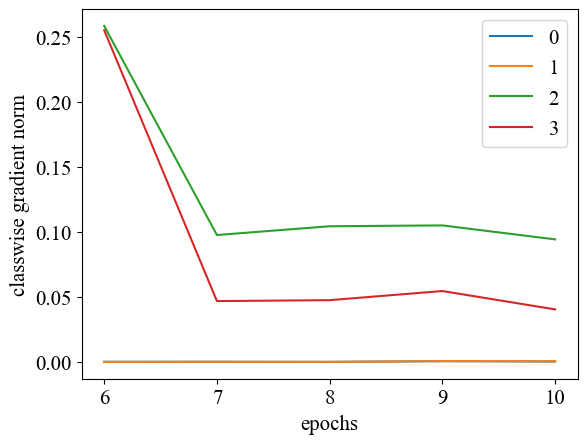

---------------------------- Task 3 -----------------------
losses=tensor([[7.6728e-04, 1.0864e-03, 1.8704e-01, 1.6052e-01, 1.3692e+01, 1.3846e+01]])
Elapsed time(grad):102.722
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):590.529
Fairness:[ 0.          0.1270417  -0.08026964  0.         -0.02338602 -0.02338596]
len(updated_seq_indices)=27776
Elapsed time(etc):0.411
[11] Eval metrics for task 1 >> {'accuracy': 0.9609502831969792, 'loss': 0.0006324228401302446, 'std': 0.003807426054122043, 'EER': -1}
[11] Eval metrics for task 2 >> {'accuracy': 0.7951694297336711, 'loss': 0.003298044146333222, 'std': 0.012001112901987854, 'EER': -1}
[11] Eval metrics for task 3 >> {'accuracy': 0.9628035582183336, 'loss': 0.00048822823915881054, 'std': 0.030068132209364995, 'EER': -1}
losses=tensor([[0.0014, 0.0009, 0.0011, 0.0014, 0.0526, 0.1949]])
Elapsed time(grad):104.933
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):674.313
Fairness:[ 0.   

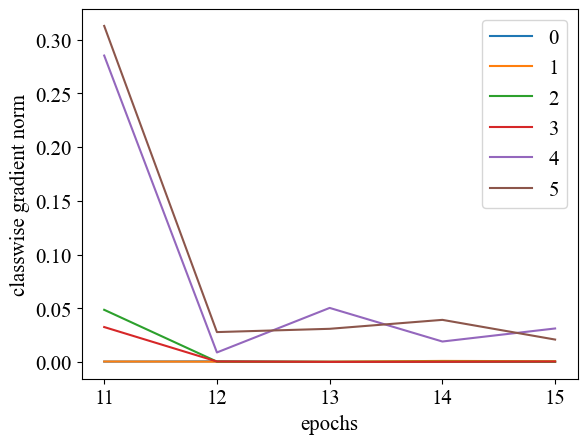

---------------------------- Task 4 -----------------------
losses=tensor([[1.9418e-04, 2.6328e-04, 4.7440e-04, 3.6291e-04, 7.7833e-02, 2.7368e-01,
         1.4907e+01, 1.3018e+01]])
Elapsed time(grad):134.45
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):972.545
Fairness:[-0.04533809  0.1175663  -0.07141499  0.12944158  0.         -0.12552545
 -0.00236505 -0.00236476]
len(updated_seq_indices)=33472
Elapsed time(etc):0.438
[16] Eval metrics for task 1 >> {'accuracy': 0.9161264946507237, 'loss': 0.0016296742021614779, 'std': 0.008983637507866571, 'EER': -1}
[16] Eval metrics for task 2 >> {'accuracy': 0.7626861232634892, 'loss': 0.004540091776357458, 'std': 0.027042558907053482, 'EER': -1}
[16] Eval metrics for task 3 >> {'accuracy': 0.8875087905162886, 'loss': 0.002138941382776584, 'std': 0.05342807302749947, 'EER': -1}
[16] Eval metrics for task 4 >> {'accuracy': 0.9531317270903228, 'loss': 0.0006193752360247894, 'std': 0.0011484285517006088, 'EER': -1}
lo

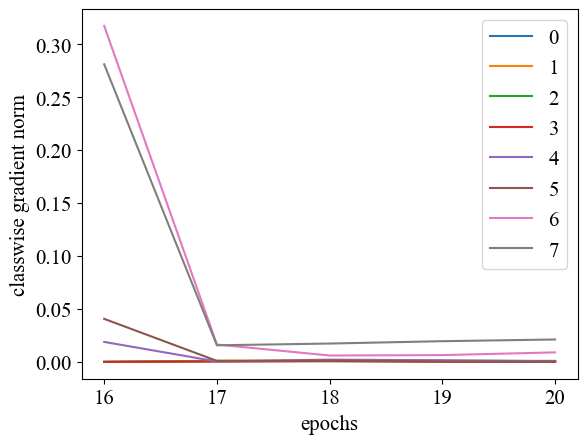

---------------------------- Task 5 -----------------------
losses=tensor([[1.8236e-03, 4.0047e-04, 5.5211e-04, 5.1629e-04, 1.0430e-03, 8.2393e-04,
         5.5968e-02, 3.2826e-02, 1.4544e+01, 1.5578e+01]])
Elapsed time(grad):126.249
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):1050.168
Fairness:[ 1.51475328e-01  1.50092896e-01  9.47154193e-02  0.00000000e+00
 -2.53118917e-01 -5.55111512e-17  5.55111512e-17  5.55111512e-17
 -7.15827035e-02 -7.15824901e-02]
len(updated_seq_indices)=34816
Elapsed time(etc):0.627
[21] Eval metrics for task 1 >> {'accuracy': 0.8863773262609008, 'loss': 0.002355414410573089, 'std': 0.004439000269711446, 'EER': -1}
[21] Eval metrics for task 2 >> {'accuracy': 0.6836384219817331, 'loss': 0.006568792751323465, 'std': 0.00047010515004985987, 'EER': -1}
[21] Eval metrics for task 3 >> {'accuracy': 0.7971536993232444, 'loss': 0.003790693164762336, 'std': 0.03482186075822202, 'EER': -1}
[21] Eval metrics for task 4 >> {'accuracy': 0.

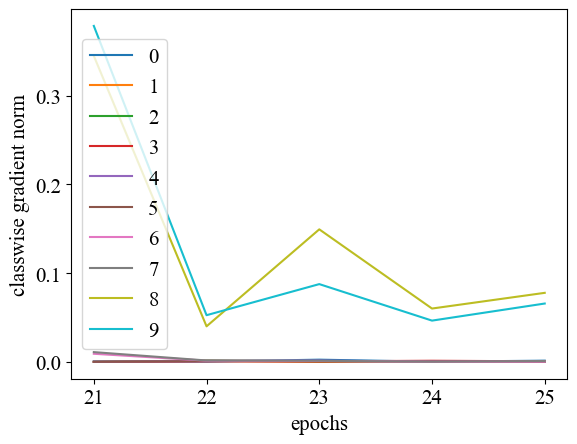

final avg-acc 0.8340069657933343
final avg-forget 0.12057913356060088


In [5]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [6]:
g = algorithm.grad_calculation_time
o = algorithm.optim_time
e = algorithm.etc_prepare_time
t = algorithm.overall_training_time


for task in range(2, 6):
    print(np.round(np.sum(list(g[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(o[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(e[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(t[task])), 4), end="\t")


627.1169	556.2648	644.7331	604.3062	
2644.7255	3277.781	5024.7973	5130.602	
2.6419	2.4694	2.4373	2.3828	
3286.4434	3847.7512	5681.558	5750.2854	

In [7]:
for task in range(2, 6):
    print(np.round(np.mean(list(o[task].values())), 4), end="\t")


528.9451	655.5562	1004.9595	1026.1204	

In [8]:
num_class_per_task = 2
num_epochs = params['epochs_per_task']

t = algorithm.true_loss
e = algorithm.expected_loss
groupwise_true_loss = dict()
groupwise_expected_loss = dict()

for i in range(num_classes):
    groupwise_true_loss[i] = dict()
    groupwise_expected_loss[i] = dict()

for task in range(2, params['num_tasks']+1):
    for epoch in range(1, num_epochs+1):
        true_loss = np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        excepted_loss = np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        for i, (tl, el) in enumerate(zip(true_loss, excepted_loss)):
            groupwise_true_loss[i][(task-1)*num_epochs+epoch] = tl
            groupwise_expected_loss[i][(task-1)*num_epochs+epoch] = el
            
    #     num_class_per_task
    #     print(np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print(np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print()
    # print()


KeyError: 1

In [ ]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_true_loss[c][ce], end='\t')
    print()


0.0931	0.0813	0.0144	0.0026	0.001	0.0045	0.0415	0.038	0.0221	0.0095	0.005	0.0301	0.0207	0.0141	0.015	0.0013	0.0225	0.0099	0.0057	0.0043	
0.0678	0.0334	0.0211	0.0064	0.002	0.001	0.0121	0.0104	0.0064	0.0056	0.0026	0.0364	0.0123	0.0136	0.0135	0.0039	0.0918	0.0218	0.0144	0.0114	
3.2512	1.1079	0.374	0.2806	0.2964	0.297	0.0685	0.0229	0.0057	0.0043	0.0678	0.138	0.0456	0.0129	0.011	0.0039	0.0353	0.0297	0.021	0.0068	
3.2823	0.9182	0.3969	0.2986	0.3075	0.1975	0.1856	0.0991	0.034	0.0151	0.0022	0.0293	0.0131	0.0106	0.009	0.0045	0.054	0.0278	0.0108	0.0087	
					4.2212	1.1061	0.3181	0.2274	0.2041	0.2428	0.141	0.0345	0.0128	0.011	0.0826	0.244	0.1573	0.1052	0.0643	
					4.774	1.0566	0.4077	0.2798	0.2442	0.5832	0.1362	0.0434	0.0183	0.0191	0.1042	0.1726	0.0463	0.0254	0.0179	
										4.9114	0.7581	0.2841	0.2757	0.2136	0.2501	0.0865	0.0374	0.0214	0.0153	
										4.5391	0.9213	0.338	0.3059	0.2664	0.3179	0.1929	0.1632	0.0935	0.0581	
															3.9846	0.514	0.2999	0.2651	0.2691	
															3.9077

In [ ]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_expected_loss[c][ce], end='\t')
    print()


0.3509	0.7387	0.278	0.1754	0.1661	0.133	0.4624	0.4374	0.377	0.317	-0.0803	0.083	0.1619	0.1087	0.1082	-0.1547	-0.0003	0.0804	0.0572	0.0595	
0.0916	0.5701	0.278	0.1754	0.1661	-0.1343	0.0394	0.058	0.0631	0.0818	-0.142	0.0513	0.104	0.0771	0.0878	-0.1743	0.2268	0.2778	0.2343	0.2251	
6.1757	0.9496	0.278	0.1754	0.1661	0.2462	0.4906	0.3007	0.212	0.149	0.2319	0.6669	0.389	0.3154	0.2738	-0.1066	0.1572	0.2899	0.2467	0.2524	
6.2965	0.6965	0.278	0.1754	0.1661	0.2	0.8171	0.5449	0.4221	0.2768	-0.1402	0.0637	0.1435	0.1029	0.1106	-0.1397	0.3163	0.2899	0.2544	0.2251	
					7.8962	0.8357	-0.0	-0.0	0.0	0.2192	0.6869	0.381	0.3122	0.2075	0.1796	0.6016	0.5878	0.5252	0.4671	
					10.075	1.0958	0.2082	-0.0	0.0	0.3896	0.3299	0.2179	0.1496	0.1384	0.0936	0.3993	0.3951	0.3071	0.2766	
										10.9757	0.6511	0.0	0.0	0.0	0.139	0.4365	0.3599	0.2953	0.2644	
										9.1554	0.8642	-0.0	0.0	-0.0	0.1672	0.7511	0.6184	0.5465	0.4809	
															11.09	0.3957	0.0	0.0	0.0	
															10.9371	0.6811	0.0	0.0	-0.0	


In [ ]:
print(f"accuracy:{np.mean(metric_manager_callback.meters['accuracy'].compute_overall())}")
print(f"EER:{np.mean(metric_manager_callback.meters['EER'].compute_overall())}")
print(f"std:{np.mean(metric_manager_callback.meters['std'].compute_overall())}")


accuracy:0.9178997309038923
EER:0.039665819416621784
std:0.04879856635600573
